## 1. Introduction
#Masked Patch Prediction Using Vision Transformers on CIFAR-10: A Self-Supervised Learning Approach

This notebook implements a simplified version of Masked Autoencoder (MAE) using Vision Transformers (ViT) on the CIFAR-10 dataset. The model is trained to reconstruct masked image patches in a self-supervised manner, encouraging it to learn meaningful visual representations without using any labels.


## 2. Setup & Dependencies


In [ ]:
#Install required libraries
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00


In [ ]:
#Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets, transforms

In [ ]:
#Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
#Set random seed for consistency
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# 3. Dataset Preparation
Here, we'll:

Load CIFAR-10 data with normalization and augmentation

Visualize some sample images

Prepare for patching and masking in the next step

In [ ]:
# Define transforms: ToTensor and Normalize with CIFAR-10 stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean of CIFAR-10
                         (0.2023, 0.1994, 0.2010))  # std of CIFAR-10
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:07<00:00, 23.2MB/s]


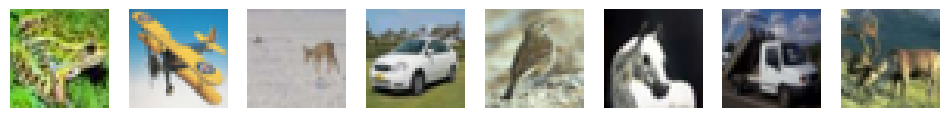

In [ ]:
# Function to unnormalize and show images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # C x H x W --> H x W x C
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')


dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 4))
for idx in range(8):
    plt.subplot(1, 8, idx+1)
    imshow(images[idx])
plt.show()

# 4. Patching & Masking
In this section, we'll:

Break the image into patches

Randomly mask some patches

Prepare them for ViT input

In [ ]:
def patchify(imgs, patch_size=4):
    """
    imgs: (B, C, H, W)
    Returns: (B, N, patch_dim)
    """
    B, C, H, W = imgs.shape
    assert H % patch_size == 0 and W % patch_size == 0

    h, w = H // patch_size, W // patch_size
    patches = imgs.reshape(B, C, h, patch_size, w, patch_size)
    patches = patches.permute(0, 2, 4, 3, 5, 1)  # [B, h, w, p, p, C]
    patches = patches.reshape(B, h * w, patch_size * patch_size * C)  # [B, N, patch_dim]
    return patches

In [ ]:
def random_masking(patches, mask_ratio=0.75):
    """
    Randomly mask a ratio of patches.
    Returns:
    - masked_patches: same shape as input, with some patches zeroed
    - mask: binary mask of shape (B, N) where 1 = masked
    """
    B, N, D = patches.shape
    len_keep = int(N * (1 - mask_ratio))

    noise = torch.rand(B, N, device=patches.device)
    ids_shuffle = noise.argsort(dim=1)
    ids_restore = ids_shuffle.argsort(dim=1)

    # keep the first part, mask the rest
    ids_keep = ids_shuffle[:, :len_keep]

    # create mask
    mask = torch.ones(B, N, device=patches.device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)

    # apply mask to patches
    masked = torch.zeros_like(patches)
    for b in range(B):
        masked[b, ids_keep[b]] = patches[b, ids_keep[b]]

    return masked, mask

In [ ]:
# Get one batch from train_loader
sample_imgs, _ = next(iter(train_loader))
sample_imgs = sample_imgs.to(device)

# Convert to patches
patches = patchify(sample_imgs)

# Mask patches
masked_patches, patch_mask = random_masking(patches, mask_ratio=0.75)

print("Original patch shape:", patches.shape)
print("Masked patch shape:", masked_patches.shape)
print("Mask shape:", patch_mask.shape)

Original patch shape: torch.Size([64, 64, 48])
Masked patch shape: torch.Size([64, 64, 48])
Mask shape: torch.Size([64, 64])


# 5. Model Architecture
Architecture Overview:

Encoder: Pretrained or tiny ViT from timm (only processes visible patches).

Decoder: A small MLP that reconstructs original patch pixels from latent vectors.

Input: Masked patches

Output: Reconstructed full patch sequence

In [ ]:
import timm

class PatchMindMAE(nn.Module):
    def __init__(self, encoder_model='vit_tiny_patch16_224',
                 patch_dim=48, embed_dim=192, decoder_dim=128, num_patches=64):
        super(PatchMindMAE, self).__init__()

        #Encoder
        self.encoder = timm.create_model(encoder_model, pretrained=True)
        self.encoder.reset_classifier(0)
        self.encoder.patch_embed.proj = nn.Linear(patch_dim, embed_dim)

        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, decoder_dim),
            nn.ReLU(),
            nn.Linear(decoder_dim, patch_dim)
        )

    def forward(self, masked_patches):
        # masked_patches: [B, N, patch_dim]
        x = self.encoder.patch_embed.proj(masked_patches)  # linear projection to embedding space
        x = self.encoder.pos_drop(x + self.encoder.pos_embed[:, 1:x.size(1)+1, :])  # positional encoding
        x = self.encoder.blocks(x)
        x = self.encoder.norm(x)

        # Decode to reconstruct patches
        out = self.decoder(x)  # [B, N, patch_dim]
        return out

In [ ]:
model = PatchMindMAE(
    encoder_model='vit_tiny_patch16_224',
    patch_dim=48,      # 4x4 patch with 3 channels → 4*4*3 = 48
    embed_dim=192,     # ViT tiny's default
    decoder_dim=128,   # latent for MLP decoder
    num_patches=64     # 32x32 / 4x4 = 64 patches
).to(device)

print("Model initialized. Total parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Model initialized. Total parameters: 5417072


# 6. Training Loop
Here’s what we’ll do:

Use MSE loss to compare reconstructed patches with original ones

Only compute loss on masked patches

Train for a few quick epochs

Visualize the loss curve

In [ ]:
def compute_loss(original, reconstructed, mask):
    """
    original, reconstructed: [B, N, patch_dim]
    mask: [B, N] (1 = masked, 0 = visible)
    """
    loss = ((original - reconstructed) ** 2).mean(dim=-1)  # [B, N]
    loss = (loss * mask).sum() / mask.sum()  # only consider masked patches
    return loss

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 10

train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        imgs, _ = batch
        imgs = imgs.to(device)

        #Patchify
        patches = patchify(imgs)  # [B, 64, 48]

        #Mask patches
        masked_patches, patch_mask = random_masking(patches, mask_ratio=0.75)

        #Forward pass
        reconstructed = model(masked_patches)

        #Compute loss
        loss = compute_loss(patches, reconstructed, patch_mask)

        #Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

Epoch 1/10 | Loss: 0.9049
Epoch 2/10 | Loss: 0.6728
Epoch 3/10 | Loss: 0.5788
Epoch 4/10 | Loss: 0.5345
Epoch 5/10 | Loss: 0.5106
Epoch 6/10 | Loss: 0.4962
Epoch 7/10 | Loss: 0.4846
Epoch 8/10 | Loss: 0.4785
Epoch 9/10 | Loss: 0.4724
Epoch 10/10 | Loss: 0.4667


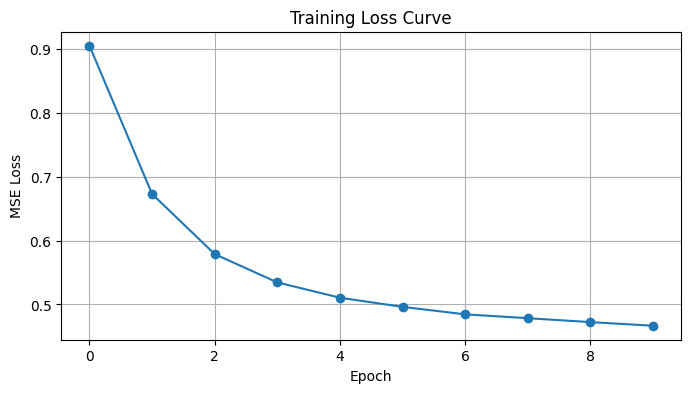

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

# 7. Evaluation — Visual Reconstruction
We’ll:

Take a few test images

Mask them

Let PatchMind reconstruct them

Compare original vs reconstructed

In [ ]:
def reconstruct_and_visualize(model, dataloader, num_images=5, mask_ratio=0.75):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:num_images].to(device)

        # Patchify
        patches = patchify(imgs)
        masked_patches, patch_mask = random_masking(patches, mask_ratio)

        # Reconstruct
        output = model(masked_patches)

        # Unpatchify for original and reconstructed
        def unpatchify(patches, patch_size=4):
            B, N, D = patches.shape
            h = w = int(N**0.5)
            C = D // (patch_size * patch_size)
            patches = patches.reshape(B, h, w, patch_size, patch_size, C)
            patches = patches.permute(0, 5, 1, 3, 2, 4).contiguous()
            imgs = patches.reshape(B, C, h * patch_size, w * patch_size)
            return imgs

        original_imgs = unpatchify(patches)
        reconstructed_imgs = unpatchify(output)
        masked_imgs = unpatchify(masked_patches)

        # Unnormalize
        def unnormalize(imgs):
            mean = torch.tensor([0.4914, 0.4822, 0.4465], device=imgs.device).view(1, 3, 1, 1)
            std = torch.tensor([0.2023, 0.1994, 0.2010], device=imgs.device).view(1, 3, 1, 1)
            return imgs * std + mean

        original_imgs = unnormalize(original_imgs).clamp(0, 1)
        reconstructed_imgs = unnormalize(reconstructed_imgs).clamp(0, 1)
        masked_imgs = unnormalize(masked_imgs).clamp(0, 1)

        # Plot
        plt.figure(figsize=(15, 6))
        for i in range(num_images):
            plt.subplot(3, num_images, i+1)
            plt.imshow(original_imgs[i].permute(1, 2, 0).cpu())
            plt.title("Original")
            plt.axis('off')

            plt.subplot(3, num_images, i+1+num_images)
            plt.imshow(masked_imgs[i].permute(1, 2, 0).cpu())
            plt.title("Masked")
            plt.axis('off')

            plt.subplot(3, num_images, i+1+2*num_images)
            plt.imshow(reconstructed_imgs[i].permute(1, 2, 0).cpu())
            plt.title("Reconstructed")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


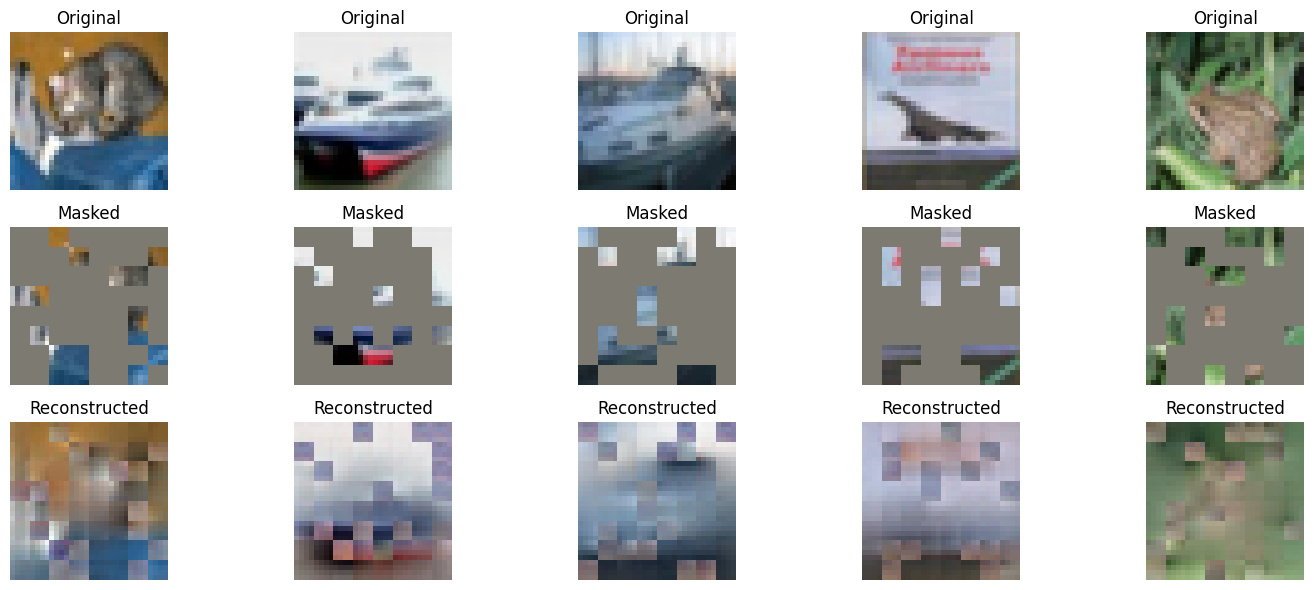

In [ ]:
reconstruct_and_visualize(model, test_loader, num_images=5, mask_ratio=0.75)